# The purpose of this project is to predict the type of food in the input photograph from the user with a machine learning model trained with the  **Food101 dataset** that contains 1000 images -750 train images, 250 test images- for 101 different food and to tell the user the nutritional values ​​of that food. 
# -> [Food101 Datasetat at Kaggle.com](https://www.kaggle.com/datasets/dansbecker/food-101)
# In this documentation, we are going to show why we choose current settings for our machine learning model.

In [ ]:
!rm -rf dataset
!rm -rf data

First, we need to import the required libraries

In [ ]:
import torch
import torchvision
from torchvision import transforms,datasets
from torch import nn
import matplotlib.pyplot as plt
from PIL import Image
import random
import numpy as np
import requests
import zipfile
from pathlib import Path
from torch.utils.data import DataLoader
import os
from tqdm.auto import tqdm
from timeit import default_timer as timer 
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import seaborn as sn

# Getting our Dataset Ready

## Downloading the images from GitHub

The **Food101 dataset** is already built-in in PyTorch but we are going to import it from my own GitHub repository. In our model we used the whole dataset but for testing I took 3 random food and 150 image of the foods from the dataset and uploaded it to GitHub therefore testing the models and troubleshooting along the way is faster and easier thanks to smaller dataset.

In [ ]:

github_path = "https://github.com/UlasTanErsoyak/food_dataset/raw/main/dataset.zip"
data_set_path = Path("dataset/") # creates path for the dataset
path = data_set_path/"3_random_food" # adds paths for the images

#check if directory exists. if it dooesn't exists create one.
if path.is_dir():
  print(f"{path} directory already exists")
else:
  print(f"cant find {path} directory. initializing it")
  path.mkdir(parents=True, exist_ok=True) 

  with open(data_set_path/"3_random_food.zip", "wb") as files:
    request = requests.get(github_path)
    print("downloading data")
    files.write(request.content)

  with zipfile.ZipFile(data_set_path/"3_random_food.zip", "r") as files:
      print("unzipping data...") 
      files.extractall(path)
      print("done!")

cant find dataset/3_random_food directory. initializing it
downloading data
unzipping data...
done!


Let's look at random images from images we imported from GitHub.

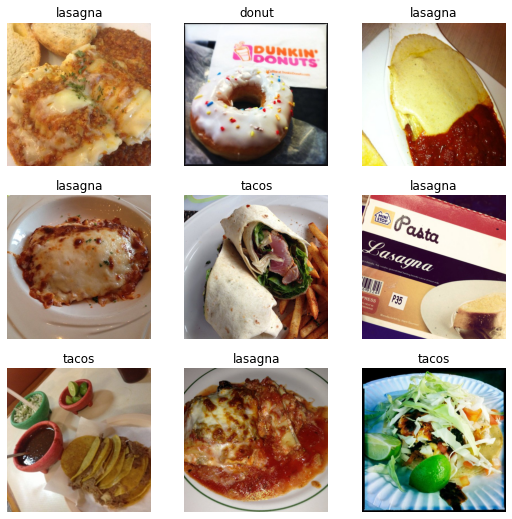

In [ ]:
image_path_list = list(path.glob("*/*/*.jpg"))# gets all image paths.


fig = plt.figure(figsize=(9, 9))
rows, cols = 3,3 # displaying 9 image in a 3 by 3 format

for i in range(1, rows * cols + 1):
    random_img = random.choice(image_path_list)# chooses a random image path from dataset folder
    img_class = random_img.parent.stem # gets parent directory of the image (the image's class)
    img = np.asarray(Image.open(random_img)) # converts the image to a numpy array so matplotlib can plot it
    fig.add_subplot(rows, cols, i) #adds a slot for displaying the image
    plt.imshow(img)#plots the image
    plt.title(img_class)#adds the image's class as the title to the plot 
    plt.axis(False)#disables the x and y axises for better visuality

In [ ]:
dataset_csv_path  = os.path.join("/content/dataset/3_random_food/train", "dataset.csv")
classes = os.listdir("/content/dataset/3_random_food/train")
donuts = os.listdir("/content/dataset/3_random_food/train/donut")
lasagna = os.listdir("/content/dataset/3_random_food/train/lasagna")
tacos = os.listdir("/content/dataset/3_random_food/train/tacos")

image_counts = [len(donuts),len(lasagna),len(tacos)]

res = {}
for key in classes:
    for value in image_counts:
        res[key] = value
        image_counts.remove(value)
        break
dataframe = pd.DataFrame(data=(res.keys(),res.values()))
dataframe

0        1      2
0  tacos  lasagna  donut
1    125      125    125

As you can see above not all images are in the same shape, it can cause problems when we work with user inputs and a bigger dataset. So we have to reshape our images to a fixed size. To reshape the images we use **torchvision.transforms**. Below i will show what happens to our images when we transform them to **64x64**, **128x128** and **256x256**, advantages and disadvantages of both of them. To make our model learn from the images we provide we have to transform the images to **tensors**.

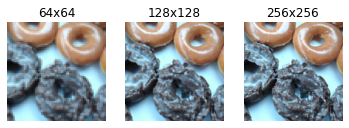

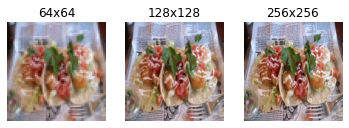

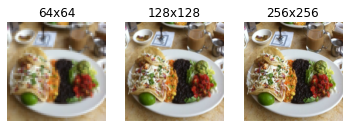

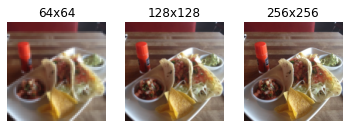

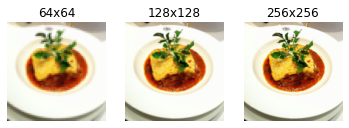

In [ ]:
transform_images_256 = transforms.Compose([
    transforms.Resize(size=(256,256)),# transforms the given image to an 256 by 256 image
    transforms.ToTensor() # transforms the given image to the pytorch tensor so our model can process it
])

transform_images_128 = transforms.Compose([
    transforms.Resize(size=(128,128)),# transforms the given image to an 128 by 128 image
    transforms.ToTensor() # transforms the given image to the pytorch tensor so our model can process it
])

transform_images_64 = transforms.Compose([
    transforms.Resize(size=(64,64)),# transforms the given image to an 64 by 64 image
    transforms.ToTensor() # transforms the given image to the pytorch tensor so our model can process it
])

random_paths = random.sample(image_path_list, k=5)
random_paths
for path in random_paths:
  with Image.open(path) as image:
    fig, ax = plt.subplots(1, 3)
    img_64 = transform_images_64(image).permute(1, 2, 0)
    # we are using permute because pytorch is using (Colour,Height,Width)
    # but matplotlib uses (Height,Width,Colour) we are changing order of the indexes
    # so matplotlib can use it
    ax[0].imshow(img_64) 
    ax[0].set_title(f"64x64")
    ax[0].axis("off")

    img_128 = transform_images_128(image).permute(1, 2, 0) 
    ax[1].imshow(img_128) 
    ax[1].set_title(f"128x128")
    ax[1].axis("off")

    img_256 = transform_images_256(image).permute(1, 2, 0) 
    ax[2].imshow(img_256) 
    ax[2].set_title(f"256x256")
    ax[2].axis("off")

**Now lets compare the results!**


> As you can see above 64x64 images are more blurry and pixelated, which can cause to the model skip some important patterns in the image but thanks to the small size model can train and learn much faster than others.


> On the other hand, 256x256 has much more details and can make our model predict really hard and confusing images if it trains with the 256x256 images. However if given a dataset big enough, 256x256 would take forever compared to others.

>128x128 offers the best of both worlds, it isn't blurry and pixelated as 64x64 therefore our model can learn patterns quite easily. And it is fairly faster compared to 256x256 so we don't have to wait for hours for training our model.

**That's why we will use 128x128 in our models from now on.**









## Convert Images to Datasets

Now we will convert our images to **Datasets**.

In [ ]:
path = data_set_path/"3_random_food" # adds paths for the images
train_dir = path / "train"
test_dir = path / "test"

train_dir, test_dir

(PosixPath('dataset/3_random_food/train'),
 PosixPath('dataset/3_random_food/test'))

In [ ]:
from torchvision import datasets

train_dataset = datasets.ImageFolder(root=train_dir,
                                  transform=transform_images_128,              
                                  )
test_dataset = datasets.ImageFolder(root=test_dir, 
                                 transform=transform_images_128,)
train_dataset , test_dataset

(Dataset ImageFolder
     Number of datapoints: 375
     Root location: dataset/3_random_food/train
     StandardTransform
 Transform: Compose(
                Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=None)
                ToTensor()
            ), Dataset ImageFolder
     Number of datapoints: 75
     Root location: dataset/3_random_food/test
     StandardTransform
 Transform: Compose(
                Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=None)
                ToTensor()
            ))

Since we turned our images to datasets we can see class names and lenght of dataset more easily.

In [ ]:
class_names = train_dataset.classes
class_names 

['donut', 'lasagna', 'tacos']

In [ ]:
class_dict = train_dataset.class_to_idx
class_dict  

{'donut': 0, 'lasagna': 1, 'tacos': 2}

In [ ]:
len(train_dataset), len(test_dataset)

(375, 75)

Lets look at 5 random images from our new datasets.

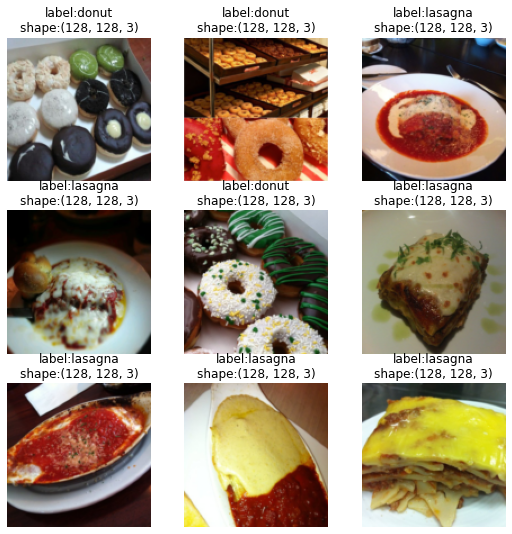

In [ ]:
fig = plt.figure(figsize=(9, 9))
rows, cols = 3,3 # displaying 9 image in a 3 by 3 format

for i in range(1, rows * cols + 1):
    random_image_index = random.randint(0,224)#taking random number between 0-224 because our dataset has 75 images per class
    img,label = train_dataset[random_image_index][0],train_dataset[random_image_index][1]
    img_permute = img.permute(1, 2, 0)
    
    img = np.asarray(img_permute) # converts the image to a numpy array so matplotlib can plot it
    fig.add_subplot(rows, cols, i) #adds a slot for displaying the image
    plt.imshow(img)#plots the image
    plt.axis(False)#disables the x and y axises for better visuality
    plt.title(f"label:{class_names[label]}\nshape:{img.shape}")


## Converting Dataset to DataLoader

We will write a function that both trains and tests the model.


Now we will convert our dataset into **DataLoaders**. Converting our dataset to the DataLoader will make it a Python iterable so we can iterate over it. Another benefit of converting is we can change the batch size of our Dataloader so our computer won't run out of memory trying to learn the whole dataset at once. Also using batch size makes our model tweak the weights and biases before seeing all of the dataset.So we can get better results after each iteration rather than each epoch.


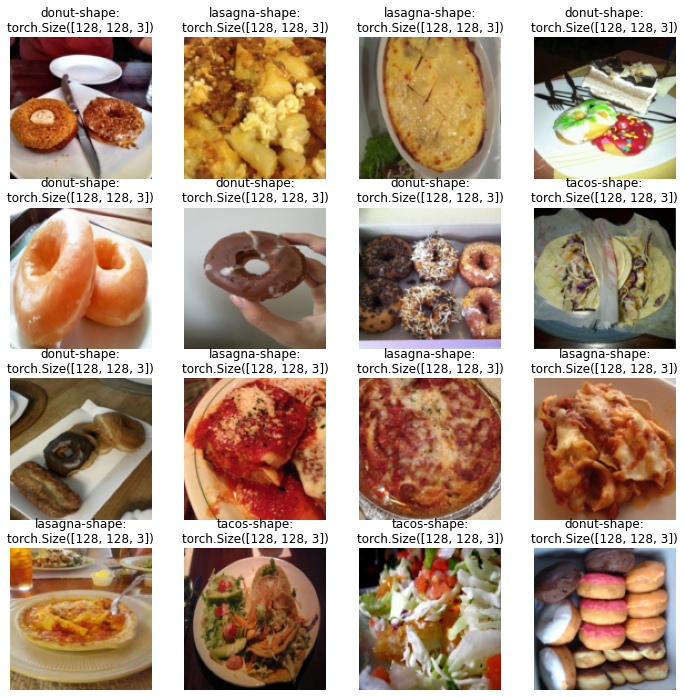

In [ ]:
BATCH_SIZE = 16
train_dataloader = DataLoader(dataset=train_dataset, 
                              batch_size=BATCH_SIZE,# number of images that dataloader is going to show per iteration
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_dataset, 
                             batch_size=BATCH_SIZE,
                             shuffle=False) 
images, label = next(iter(train_dataloader))

fig = plt.figure(figsize=(12,12))
rows, cols = 4,4 # displaying 16 image in a 4 by 4 format

for i in range(1, rows * cols + 1):
    img_permute = images[i-1].permute(1, 2, 0)
    
    img = np.asarray(img_permute) # converts the image to a numpy array so matplotlib can plot it
    fig.add_subplot(rows, cols, i) #adds a slot for displaying the image
    plt.imshow(img)#plots the image
    plt.title(img_class)#adds the image's class as the title to the plot 
    plt.axis(False)#disables the x and y axises for better visuality
    plt.title(f"{class_names[label[i-1]]}-shape:\n{img_permute.shape}")

# Train and Test Function

Now lets iterate through our new **Dataloader** and look at one batch of pictures.

In [ ]:
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),#we are using CrossEntryopyLoss because it works really well with the classification problems.
                                                           #->https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html
          epochs=5):
    
    results = {"train_loss": [],"train_acc": [],"test_loss": [],"test_acc": []}
    for epoch in tqdm(range(epochs)):

      model.train()
      train_loss, train_acc = 0, 0
      for batch, (X, y) in enumerate(train_dataloader):
          X, y = X.to(device), y.to(device)#puts the image batch and label to the device so we can use cuda
          y_pred = model(X) # gets the prediction from the model
          loss = loss_fn(y_pred, y) # compares the result of the model with the real results
          train_loss += loss.item() 
          optimizer.zero_grad() # sets grads to none so it has a this will in general have lowers memory footprint
          loss.backward()
          optimizer.step()
          y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)#takes the label with highest probability and makes a prediction based on it
          train_acc += (y_pred_class == y).sum().item()/len(y_pred) #divides correct guesses to the length of all data to find accuracy
      train_loss = train_loss / len(train_dataloader)
      train_acc = train_acc / len(train_dataloader)


      model.eval() 
      test_loss, test_acc = 0, 0
      with torch.inference_mode():
          for batch, (X, y) in enumerate(test_dataloader):
              X, y = X.to(device), y.to(device)#puts the image batch and label to the device so we can use cuda
              test_pred = model(X)
              loss = loss_fn(test_pred, y)
              test_loss += loss.item()
              test_pred_labels = test_pred.argmax(dim=1) #takes the label with highest probability and makes a guess based on it
              test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

      test_loss = test_loss / len(test_dataloader)
      test_acc = test_acc / len(test_dataloader)
      print(f"Epoch: {epoch+1} | "f"train_loss: {train_loss:.4f} | "f"train_acc: {(train_acc*100):.2f} | "f"test_loss: {test_loss:.4f} | "f"test_acc: {(test_acc*100):.2f}")    
      results["train_loss"].append(train_loss)
      results["train_acc"].append(train_acc)
      results["test_loss"].append(test_loss)
      results["test_acc"].append(test_acc)

    return results

# Confusion Matrix Function

We will write a function that will plot the confusion matrix of a model. Confusion Matrix basically shows what our model predicted in a pandas dataframe. This way we will be able to see which classes confuses our model. An ideal confusion matrix should have a diagonal straight line going from top left to top right. What this means is model guesses every single input correctly and works with %100 accuracy.


A confusion matrix close to an ideal confusion matrix.
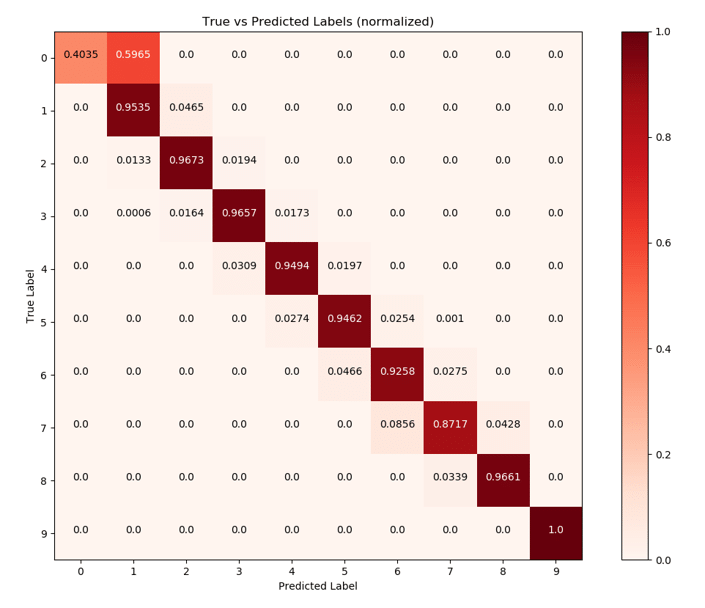

In [ ]:
def show_confusion(model,
                   test_datalaoder,
                   test_dataset
                   ):
  y_pred = []
  y_true = []

  # iterate over test data
  for inputs, labels in test_datalaoder:
          output = model(inputs) # get the predictions from model

          output = (torch.max(torch.exp(output), 1)[1]).data.numpy() # transform predictions to labels
          y_pred.extend(output) # save the models prediction so we can compare it with the ground truth later on
          
          labels = labels.data.numpy()
          y_true.extend(labels) # saves the true labels

  classes = test_dataset.classes # gets the name of the classes so we can use them in  matrix's rows and colums 

  cf_matrix = confusion_matrix(y_true, y_pred) # builds the confusion matrix
  df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes], columns = [i for i in classes])# visualizes the confusion matrix by converting the numpy 
                                                                                                                     #array return of previous line to a pandas dataframe
  plt.figure(figsize = (12,7))
  sn.heatmap(df_cm, annot=True)

# Function to visualize loss and accuracy


We will write a function that takes output of the Train and Test function that we coded above as input and plot them using matplotlib library.

In [ ]:
def plot_statistics(results):

    loss1 = results['train_loss']
    test_loss = results['test_loss']
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']
    epochs = range(len(results['train_loss']))
 
    plt.figure(figsize=(15, 7))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss1, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('loss')
    plt.xlabel('epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('accuracy')
    plt.xlabel('epochs')
    plt.legend()

# Why We Choose Current Settings For Our Model

Setting device-agnostic code so our model can use Cuda if it is available

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## Linearity vs Non-*Linearity*

Lets test which one works best with our classification problem. **Linearity** or **non-linearity**? Can our model classify food images without **linearity**? We will start with the **linear** model and continue with the **non-linear** model then compare their loss and accuracy results to each other and determine which to use in our model. 

We will code a model with **3 linear layers** and nothing more.

In [ ]:
class Model_with_Linearity(nn.Module):
  def __init__(self,input_shape : int,hidden_units : int,output_shape : int)-> None:

    super().__init__()
    self.layers = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=input_shape,out_features=hidden_units),
        nn.Linear(in_features=hidden_units,out_features=hidden_units),
        nn.Linear(in_features=hidden_units,out_features=output_shape)
    )
  def forward(self,x):
    return self.layers(x)

In [ ]:
linear_model = Model_with_Linearity(input_shape=128*128*3,# 128*128*3 3 for (R,G,B) channels and 128*128 for the 128x128 pixel of the image
                                           hidden_units=100,
                                           output_shape=len(train_dataset.classes)).to(device)
linear_model

Model_with_Linearity(
  (layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=49152, out_features=100, bias=True)
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): Linear(in_features=100, out_features=3, bias=True)
  )
)

In [ ]:
class Model_with_nonLinearity(nn.Module):
  def __init__(self,input_shape : int,hidden_units : int,output_shape : int)-> None:

    super().__init__()
    self.layers = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=input_shape,out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units,out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units,out_features=output_shape)
    )
  def forward(self,x):
    return self.layers(x)

In [ ]:
nonlinear_model = Model_with_nonLinearity(input_shape=128*128*3,# 128*128*3 | 3 for (R,G,B) channels | 128*128 for the 128x128 pixel of the image
                                           hidden_units=100,
                                           output_shape=len(train_dataset.classes)).to(device)
nonlinear_model

Model_with_nonLinearity(
  (layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=49152, out_features=100, bias=True)
    (2): ReLU()
    (3): Linear(in_features=100, out_features=100, bias=True)
    (4): ReLU()
    (5): Linear(in_features=100, out_features=3, bias=True)
  )
)

Now let's test both of our models. 

In [ ]:
NUM_EPOCHS = 10
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=nonlinear_model.parameters(), lr=0.01)

start_time = timer()

nonlinearmodelresults = train(model=nonlinear_model, 
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)

end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 24.0721 | train_acc: 35.31 | test_loss: 1.4109 | test_acc: 37.61
Epoch: 2 | train_loss: 1.2010 | train_acc: 36.09 | test_loss: 1.1597 | test_acc: 37.61
Epoch: 3 | train_loss: 1.1065 | train_acc: 35.64 | test_loss: 1.0993 | test_acc: 31.25
Epoch: 4 | train_loss: 1.1022 | train_acc: 32.55 | test_loss: 1.0982 | test_acc: 31.25
Epoch: 5 | train_loss: 1.0986 | train_acc: 35.12 | test_loss: 1.0970 | test_acc: 37.50
Epoch: 6 | train_loss: 1.1000 | train_acc: 28.16 | test_loss: 1.0982 | test_acc: 37.50
Epoch: 7 | train_loss: 1.0995 | train_acc: 33.56 | test_loss: 1.0978 | test_acc: 37.50
Epoch: 8 | train_loss: 1.0992 | train_acc: 33.56 | test_loss: 1.0981 | test_acc: 37.50
Epoch: 9 | train_loss: 1.1004 | train_acc: 32.55 | test_loss: 1.0974 | test_acc: 37.50
Epoch: 10 | train_loss: 1.0997 | train_acc: 31.14 | test_loss: 1.0996 | test_acc: 31.25
Total training time: 55.362 seconds


In [ ]:
NUM_EPOCHS = 10
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=linear_model.parameters(), lr=0.01)

start_time = timer()

linearmodelresults = train(model=linear_model, 
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)

end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 208.7753 | train_acc: 32.51 | test_loss: 22.0871 | test_acc: 31.25
Epoch: 2 | train_loss: 15.4015 | train_acc: 36.42 | test_loss: 11.3014 | test_acc: 38.75
Epoch: 3 | train_loss: 4.5976 | train_acc: 38.62 | test_loss: 2.7295 | test_acc: 40.80
Epoch: 4 | train_loss: 2.0245 | train_acc: 46.06 | test_loss: 1.5875 | test_acc: 47.84
Epoch: 5 | train_loss: 1.1036 | train_acc: 54.80 | test_loss: 1.3434 | test_acc: 42.50
Epoch: 6 | train_loss: 0.9390 | train_acc: 59.34 | test_loss: 1.1581 | test_acc: 51.70
Epoch: 7 | train_loss: 0.8526 | train_acc: 64.62 | test_loss: 1.3513 | test_acc: 47.27
Epoch: 8 | train_loss: 0.7916 | train_acc: 67.11 | test_loss: 1.1450 | test_acc: 58.41
Epoch: 9 | train_loss: 0.8476 | train_acc: 61.50 | test_loss: 1.2121 | test_acc: 52.84
Epoch: 10 | train_loss: 0.8306 | train_acc: 62.65 | test_loss: 1.4498 | test_acc: 43.41
Total training time: 41.648 seconds


**Linear Model's** loss and accuracy graphs:

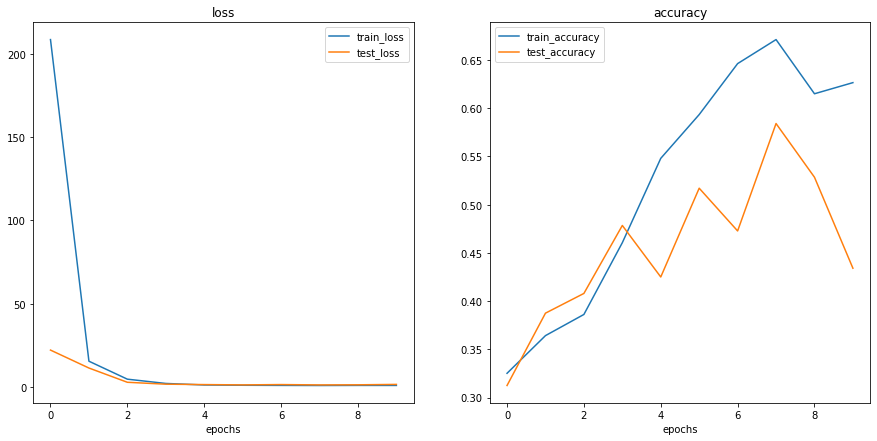

In [ ]:
plot_statistics(linearmodelresults)

**Linear Model's** confusion matrix:

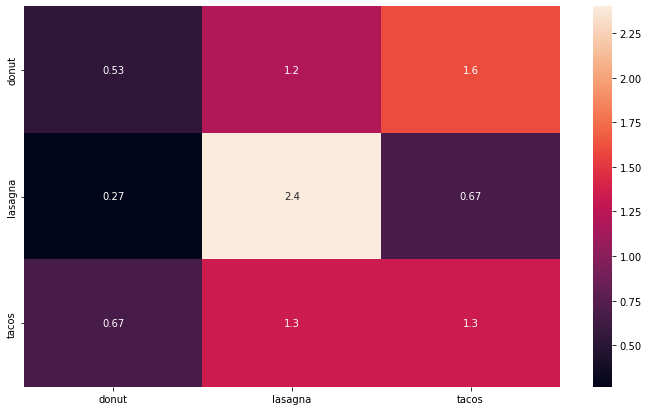

In [ ]:
show_confusion(linear_model,test_dataloader,test_dataset)

**Non-Linear Model's** loss and accuracy graphs:



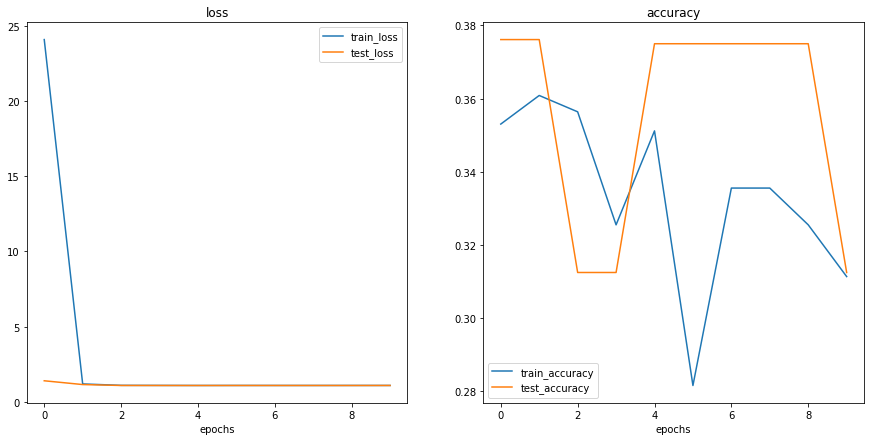

In [ ]:
plot_statistics(nonlinearmodelresults)

**Non-Linear Model's** confusion matrix:


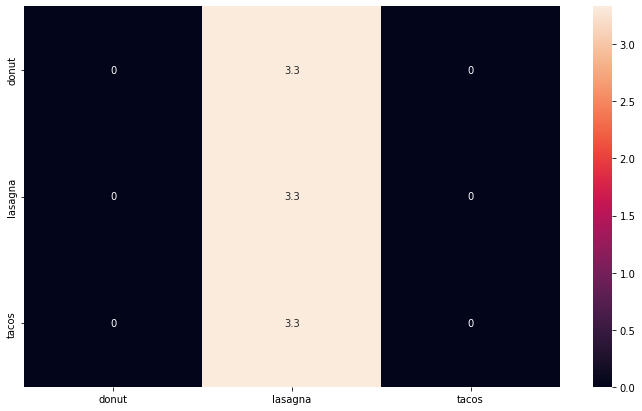

In [ ]:
show_confusion(nonlinear_model,test_dataloader,test_dataset)

## **TinyVGG Model**

Now we will compare our **non-linear model** with a **convolutional neural network** and see the results. Our neural network we will replicate TinyVGG model used in [CNN Explainer website](https://poloclub.github.io/cnn-explainer/).

Now lets build a model with a convolutional neural network that replicates TinyVGG model.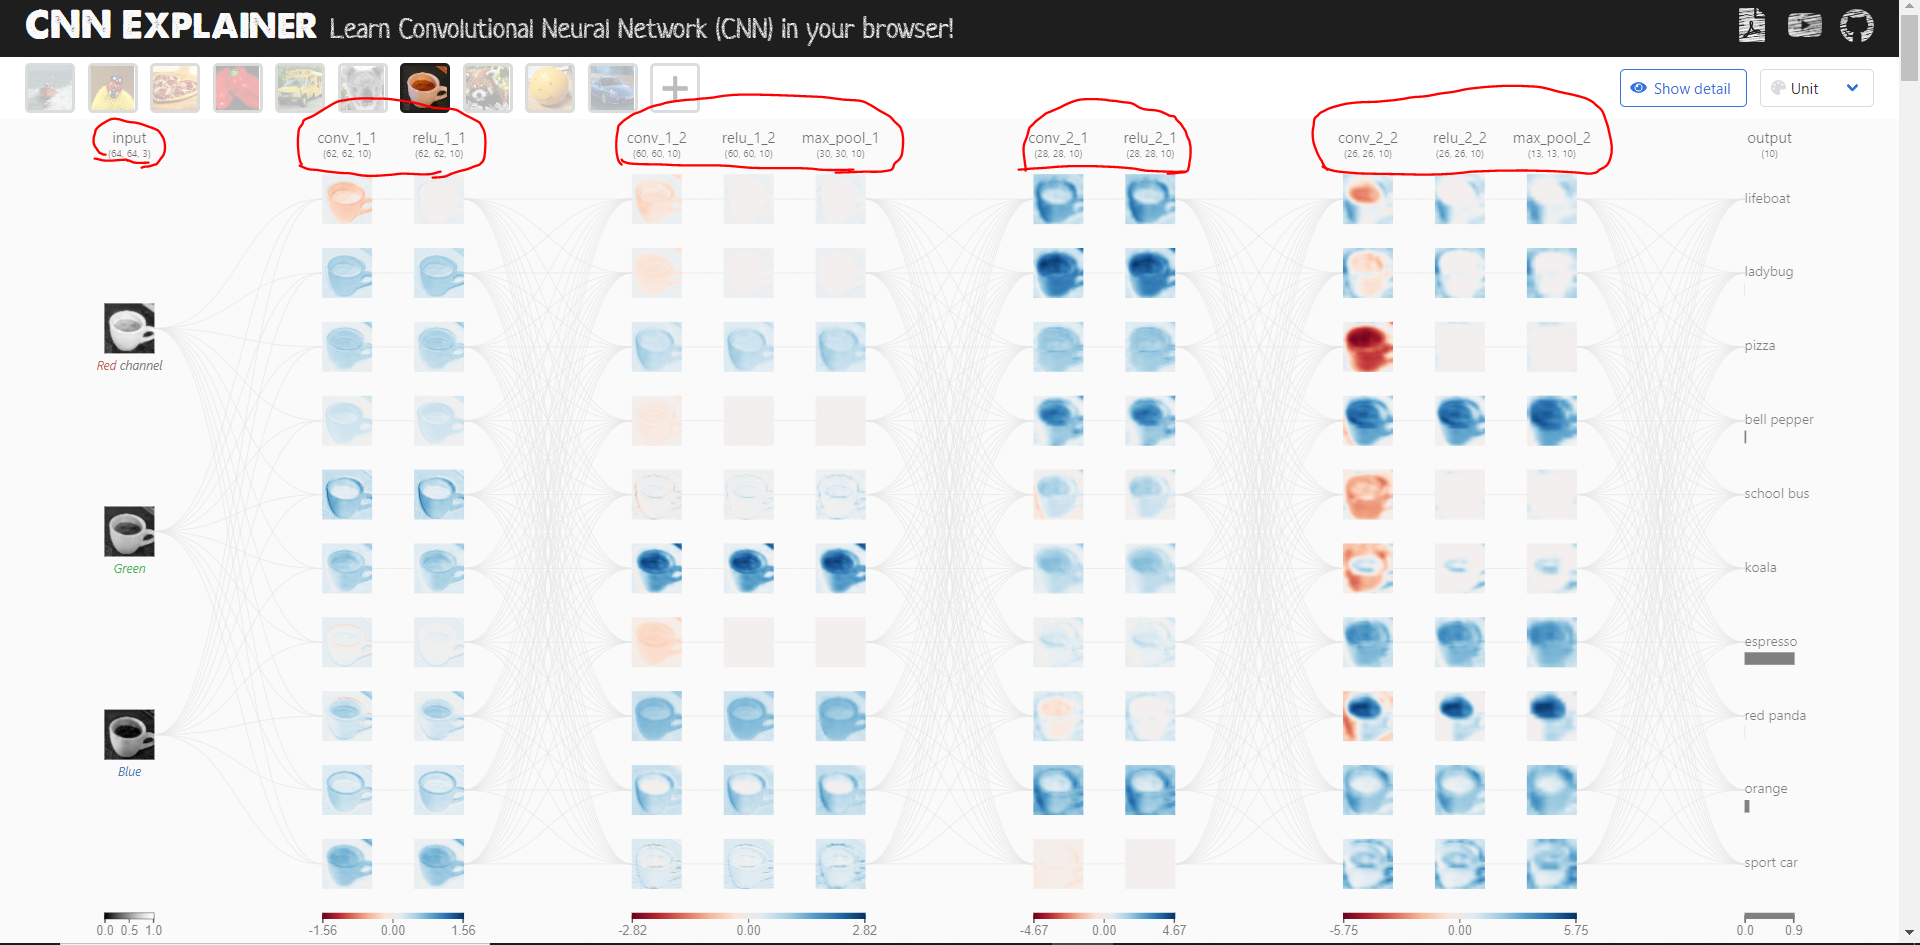

In [ ]:
class TinyVGG(nn.Module):
    def __init__(self, input_shape: int,
                 hidden_units:
                 int, output_shape: int) :
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units, kernel_size=3,stride=1,padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.LeakyReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*32*32,out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor):
      return self.classifier(self.conv_block_2(self.conv_block_1(x))) 

In [ ]:
NUM_EPOCHS = 10
model_0 = TinyVGG(input_shape=3,
                  hidden_units=10, 
                  output_shape=len(train_dataset.classes)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

from timeit import default_timer as timer 
start_time = timer()

model_0_results = train(model=model_0, 
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1397 | train_acc: 29.76 | test_loss: 1.1035 | test_acc: 31.25
Epoch: 2 | train_loss: 1.0963 | train_acc: 33.15 | test_loss: 1.0919 | test_acc: 40.68
Epoch: 3 | train_loss: 1.0943 | train_acc: 36.01 | test_loss: 1.0862 | test_acc: 39.77
Epoch: 4 | train_loss: 1.0521 | train_acc: 45.61 | test_loss: 1.0891 | test_acc: 40.00
Epoch: 5 | train_loss: 0.9975 | train_acc: 48.29 | test_loss: 1.0595 | test_acc: 46.48
Epoch: 6 | train_loss: 0.9911 | train_acc: 51.26 | test_loss: 1.0501 | test_acc: 48.30
Epoch: 7 | train_loss: 0.8233 | train_acc: 63.13 | test_loss: 1.0834 | test_acc: 52.16
Epoch: 8 | train_loss: 0.6551 | train_acc: 75.63 | test_loss: 1.2088 | test_acc: 52.73
Epoch: 9 | train_loss: 0.3959 | train_acc: 85.42 | test_loss: 1.4840 | test_acc: 47.27
Epoch: 10 | train_loss: 0.1691 | train_acc: 95.57 | test_loss: 2.2918 | test_acc: 52.16
[INFO] Total training time: 93.142 seconds


Lets compare our CNN's results with previous models.

**TinyVGG Model's** loss and accuracy graphs:


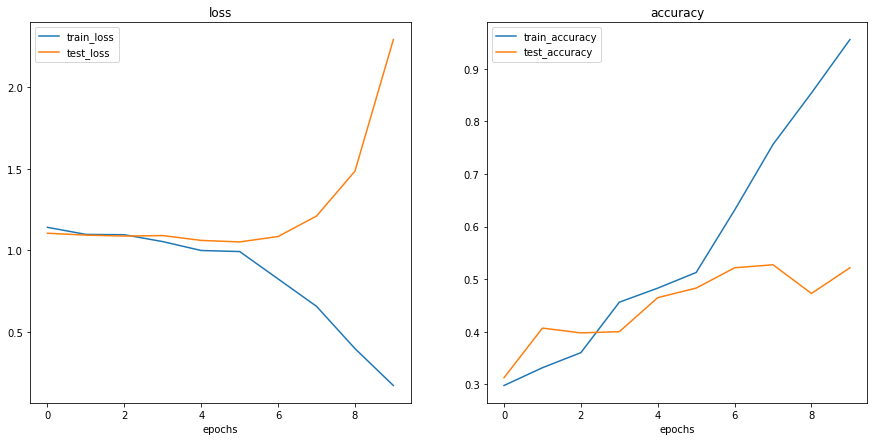

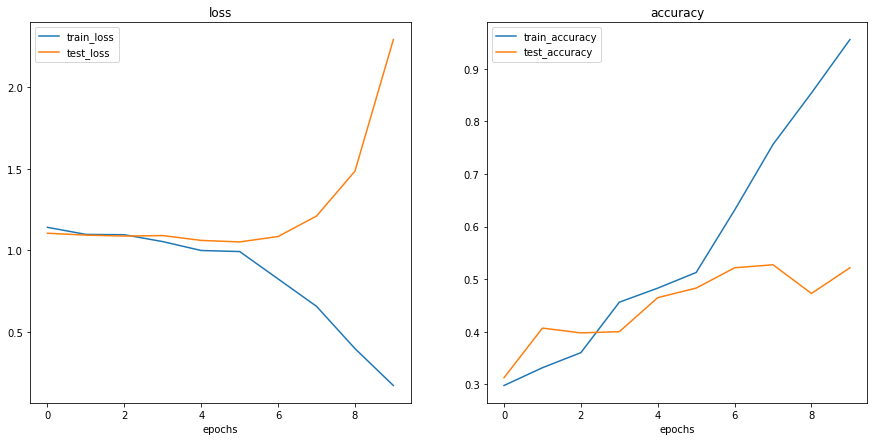

In [ ]:
plot_statistics(model_0_results)

**TinyVGG Model's** confusion matrix:


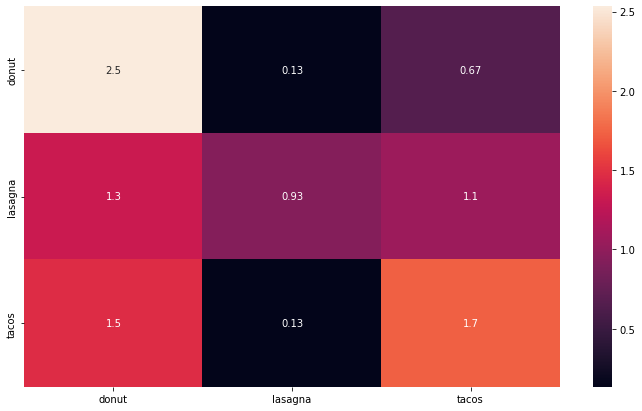

In [ ]:
show_confusion(model_0,test_dataloader,test_dataset)

Our Convolutional Neural Network performed better than our previous models. But there is still a problem. Accuracy is still low for a accurate model. We will try another model architecture.


## **ConvNet Model**


This time we will try  a ConvNet replica. Below you can see the architecture of the said model.

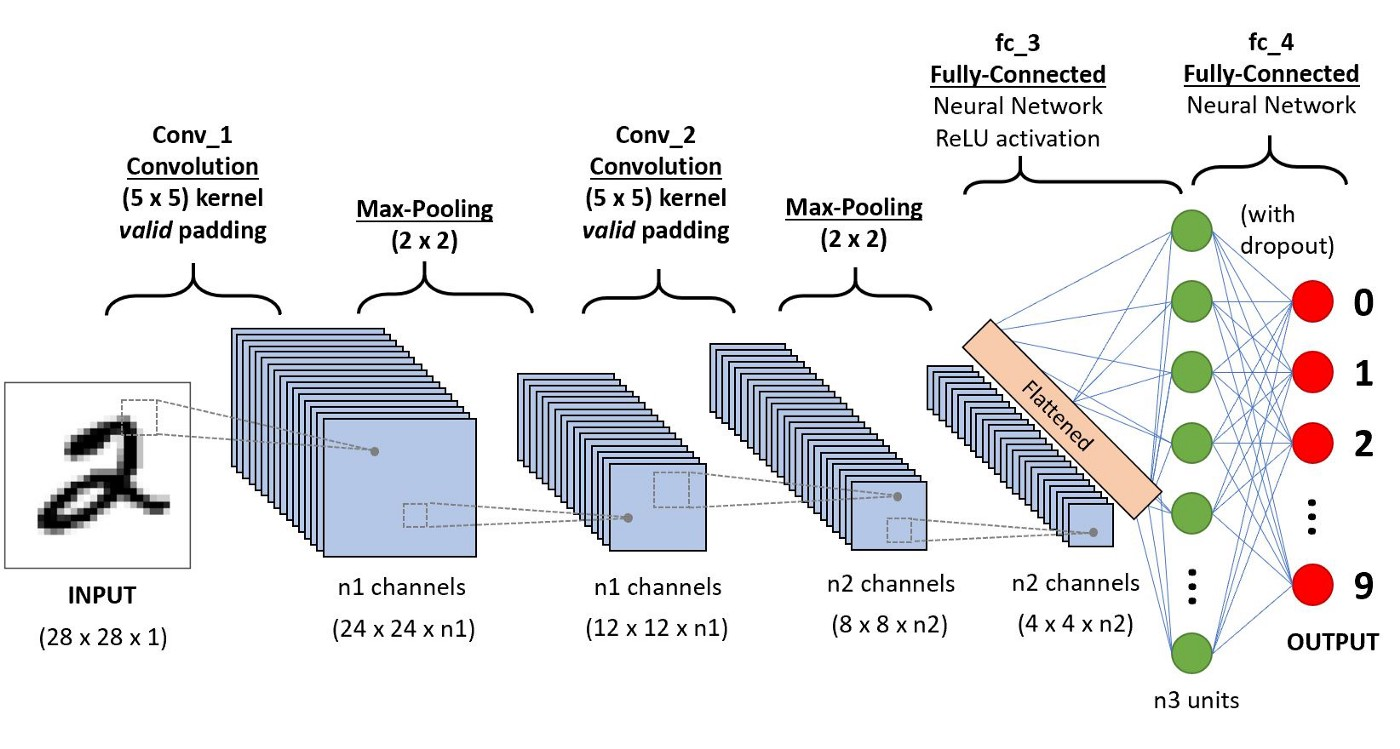

In [ ]:
class ConvNet(nn.Module):
    def __init__(self,num_classes=3):
        super(ConvNet,self).__init__()
        
        #Output size after convolution filter
        #((w-f+2P)/s) +1   
        #Input shape= (32,3,128,128)   
        self.conv1=nn.Conv2d(in_channels=3,out_channels=12,kernel_size=3,stride=1,padding=1)
        #Shape= (32,12,128,128)
        self.bn1=nn.BatchNorm2d(num_features=12)
        #Shape= (32,12,128,128)
        self.relu1=nn.ReLU()
        #Shape= (32,12,128,128)
        self.pool=nn.MaxPool2d(kernel_size=2)
        #Reduce the image size be factor 2
        #Shape= (32,12,64,64)
        self.conv2=nn.Conv2d(in_channels=12,out_channels=20,kernel_size=3,stride=1,padding=1)
        #Shape= (32,20,64,64)
        self.relu2=nn.ReLU()
        #Shape= (32,20,64,64)  
        self.conv3=nn.Conv2d(in_channels=20,out_channels=32,kernel_size=3,stride=1,padding=1)
        #Shape= (32,32,64,64)
        self.bn3=nn.BatchNorm2d(num_features=32)
        #Shape= (32,32,64,64)
        self.relu3=nn.ReLU()
        #Shape= (32,32,64,64) 
        self.fc=nn.Linear(in_features=64 * 64 * 32,out_features=num_classes) 
        #Feed forwad function   
    def forward(self,input):
        output=self.conv1(input)
        output=self.bn1(output)
        output=self.relu1(output)     
        output=self.pool(output)    
        output=self.conv2(output)
        output=self.relu2(output)        
        output=self.conv3(output)
        output=self.bn3(output)
        output=self.relu3(output)    
        #Above output will be in matrix form, with shape (32,32,64,64)
        output=output.view(-1,32*64*64)
        output=self.fc(output)
        return output

In [ ]:
NUM_EPOCHS = 10
model_1 = ConvNet(num_classes=len(class_names)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.001)

from timeit import default_timer as timer 
start_time = timer()

model_1_results = train(model=model_1, 
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 16.1153 | train_acc: 39.96 | test_loss: 3.3772 | test_acc: 43.75
Epoch: 2 | train_loss: 3.5524 | train_acc: 69.46 | test_loss: 3.5498 | test_acc: 46.82
Epoch: 3 | train_loss: 0.9642 | train_acc: 88.54 | test_loss: 5.4417 | test_acc: 52.84
Epoch: 4 | train_loss: 0.5633 | train_acc: 89.69 | test_loss: 5.6629 | test_acc: 47.16
Epoch: 5 | train_loss: 0.1865 | train_acc: 96.61 | test_loss: 4.9031 | test_acc: 52.73
Epoch: 6 | train_loss: 0.0745 | train_acc: 98.44 | test_loss: 4.8325 | test_acc: 52.16
Epoch: 7 | train_loss: 0.0083 | train_acc: 99.74 | test_loss: 4.0774 | test_acc: 55.34
Epoch: 8 | train_loss: 0.0001 | train_acc: 100.00 | test_loss: 4.1787 | test_acc: 55.34
Epoch: 9 | train_loss: 0.0002 | train_acc: 100.00 | test_loss: 4.3422 | test_acc: 52.84
Epoch: 10 | train_loss: 0.0001 | train_acc: 100.00 | test_loss: 4.2866 | test_acc: 52.84
[INFO] Total training time: 109.630 seconds


**TinyVGG Model's** loss and accuracy graphs:


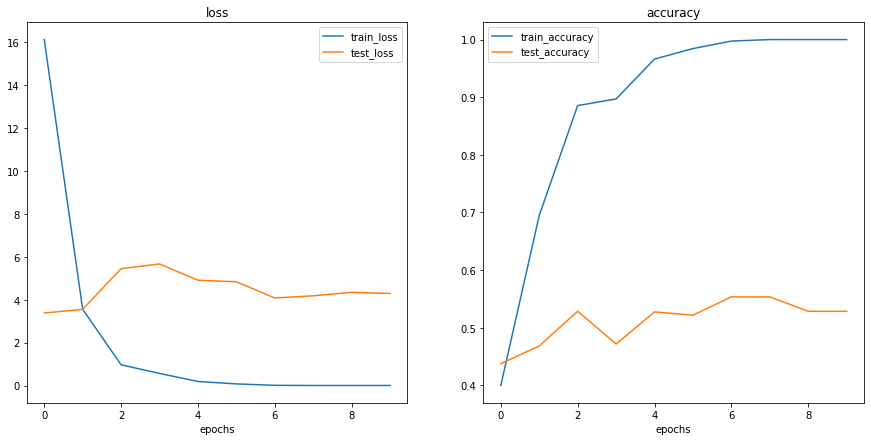

In [ ]:
plot_statistics(model_1_results)

**TinyVGG Model's** loss and confusion matrix:


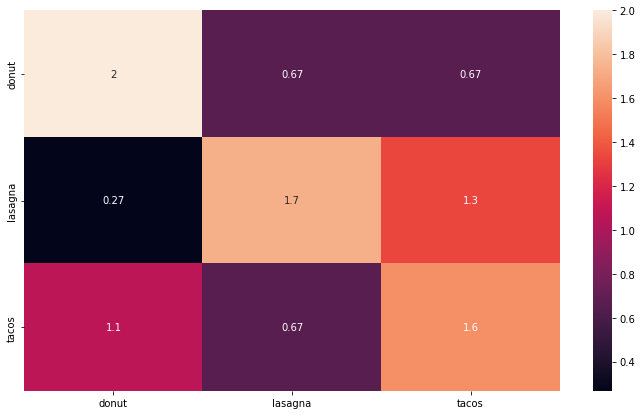

In [ ]:
show_confusion(model_1,test_dataloader,test_dataset)

ConvNet performed much better than TinyVGG but still, it isn't enough for a accurate model.We will try another model and see how it works on our dataset.

## **Pre-Trained Model Model**


This time we will try  a pre-trained version of EfficientNet B0 model. Below you can see the architecture of the said model.

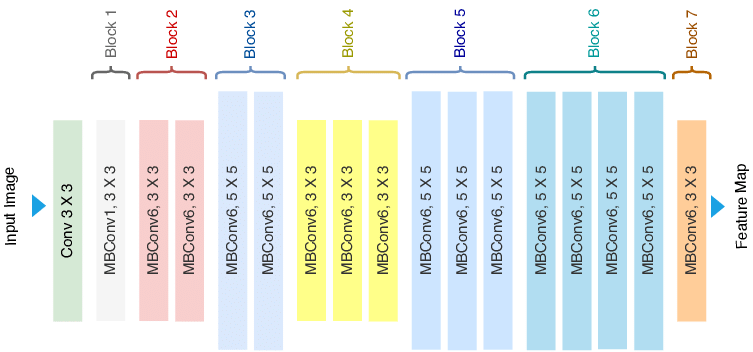

In [ ]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights 
model_2 = torchvision.models.efficientnet_b0(weights=weights) # setting weights of our model equal to the default value of the 
                                                      #pre-trained one because they are really close to perfection

In [ ]:
for param in model_2.features.parameters():
    param.requires_grad = False

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model_2.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=1280, 
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True))

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_2.parameters(), lr=0.01)

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

start_time = timer()

model_2_results = train(model=model_2,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10)
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.6520 | train_acc: 70.09 | test_loss: 0.3290 | test_acc: 85.68
Epoch: 2 | train_loss: 0.4121 | train_acc: 84.93 | test_loss: 0.4254 | test_acc: 79.55
Epoch: 3 | train_loss: 0.4707 | train_acc: 85.08 | test_loss: 0.4690 | test_acc: 83.30
Epoch: 4 | train_loss: 0.3026 | train_acc: 88.47 | test_loss: 0.5144 | test_acc: 77.16
Epoch: 5 | train_loss: 0.3123 | train_acc: 89.58 | test_loss: 0.4919 | test_acc: 83.18
Epoch: 6 | train_loss: 0.2285 | train_acc: 91.15 | test_loss: 0.5972 | test_acc: 80.23
Epoch: 7 | train_loss: 0.2499 | train_acc: 90.03 | test_loss: 0.4751 | test_acc: 83.86
Epoch: 8 | train_loss: 0.2386 | train_acc: 90.14 | test_loss: 0.5476 | test_acc: 86.93
Epoch: 9 | train_loss: 0.3260 | train_acc: 89.77 | test_loss: 0.5444 | test_acc: 88.75
Epoch: 10 | train_loss: 0.1882 | train_acc: 91.59 | test_loss: 0.5669 | test_acc: 80.23
[INFO] Total training time: 167.301 seconds


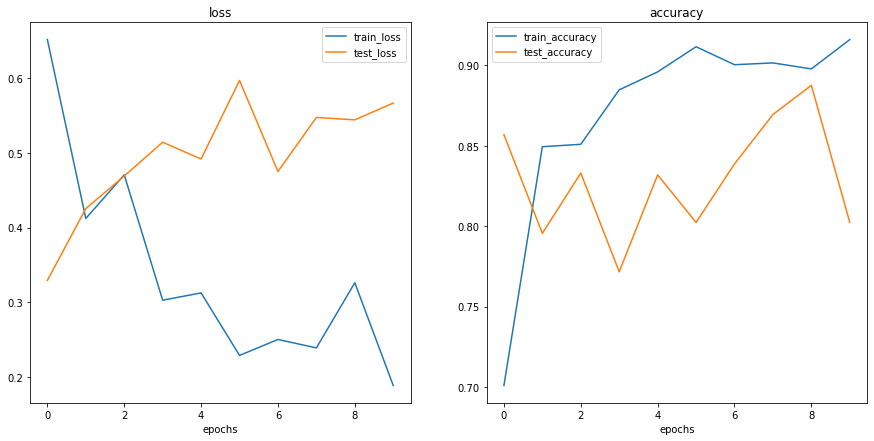

In [ ]:
plot_statistics(model_2_results)

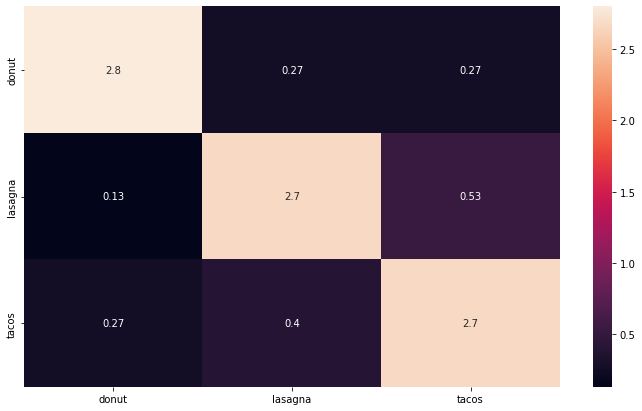

In [ ]:
show_confusion(model_2,test_dataloader,test_dataset)

This looks promising! %86 test accuracy in just 10 epoch and a proeper confusion matrix. It outperformed everything we have tried before so we will use this model on our project. 

# Getting Food101 Dataset Ready

Now we will work on the **Food101** dataset itself. 

First, we will determine what transforms to use on our train data then we will download the Food101 dataset. We choose to add random noise to the training data for now. After we train our model with the noisy data, depending on the results we might change it in the future.

In [ ]:
train_transforms = transforms.Compose([
    transforms.Resize((128, 128)), #use 128x128 to set all images to the same size
    transforms.TrivialAugmentWide(num_magnitude_bins=31), # how intense  the transformation will be
    transforms.ToTensor() # use ToTensor() last to get everything between 0 & 1
])


#we dont need to use any transformation on the test set
test_transforms = transforms.Compose([
    transforms.Resize((128, 128)), 
    transforms.ToTensor()
])


In [ ]:
start_time = timer()
train_data = datasets.Food101(
    root="data", # data path
    split="train", # training data
    download=True, # download data if it doesn't exist on disk
    transform=train_transforms, # transform our images to tensors and resize them
    target_transform=None
)
  
test_data = datasets.Food101(
    root="data",
    split="test", # testing data
    download=True,
    transform=test_transforms
)
end_time = timer()
print(f"completed the downlad in {(end_time-start_time)/60}m { {(end_time-start_time)%60}}s")

  0%|          | 0/4996278331 [00:00<?, ?it/s]

Extracting data/food-101.tar.gz to data
completed the downlad in 5.04436544333333m {2.661926599999788}s


We have successfully downloaded the dataset and performed augmentation on it. Lets see an image from our dataset.

In [ ]:
class_names = train_data.classes
class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

Text(0.5, 1.0, 'churros')

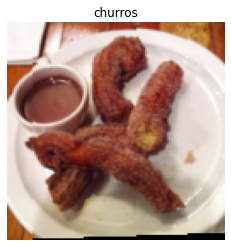

In [ ]:
image, label = train_data[0]
image_permuted = image.permute(1,2,0) # transform image from (Color,Height,Width) to (Height,Width,Colour) so matplotlib can plot it.
img_as_array = np.asarray(image_permuted) #matplotlib cant plot tensors so we transform our image to a np.array
plt.imshow(img_as_array)
plt.axis(False)
plt.title(class_names[label])

In [ ]:
image.shape # 3-> R,G,B || 128x128 from resizing image

torch.Size([3, 128, 128])

Our datasets are working as intended so lets create dataloaders from our datasets. Dataloaders turns our datasets into Python iterables so we can use them more easily.

In [ ]:
BATCH_SIZE = 32

train_dataloader = DataLoader(train_data,
    batch_size=BATCH_SIZE, 
    shuffle=True 
)

test_dataloader = DataLoader(test_data,
    batch_size=BATCH_SIZE,
    shuffle=False #
)

print(f"Dataloaders: {train_dataloader, test_dataloader}") 
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x7f8029b96d30>, <torch.utils.data.dataloader.DataLoader object at 0x7f8029b96c70>)
Length of train dataloader: 2368 batches of 32
Length of test dataloader: 790 batches of 32


In [ ]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 3, 128, 128]), torch.Size([32]))

Image size: torch.Size([3, 128, 128])
Label: 8, label size: torch.Size([])


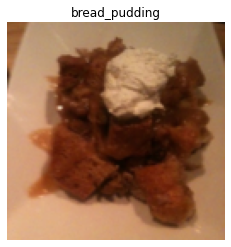

In [ ]:
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(img.permute(1,2,0).squeeze(), cmap="gray")
plt.title(class_names[label])
plt.axis(False);
print(f"Image size: {img.shape}")
print(f"Label: {label}, label size: {label.shape}")

# Getting Our Model Ready

We have downloaded the Food101 dataset, performed an augmentation on it and converted it to dataloaders. Now we will use the pre-trained model on full dataset and see some results.

Now that we have built our model lets train it using the train functions we wrote at the beginning of this notebook.

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [ ]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights 
Last_Model = torchvision.models.efficientnet_b0(weights=weights) # setting weights of our model equal to the default value of the 
                                                      #pre-trained one because they are really close to perfection

In [ ]:
for param in Last_Model.features.parameters():
    param.requires_grad = False

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
Last_Model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=1280, 
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True))

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(Last_Model.parameters(), lr=0.01)

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

start_time = timer()

Last_Model_results = train(model=Last_Model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=1)
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 6.3609 | train_acc: 16.93 | test_loss: 5.0382 | test_acc: 29.03
[INFO] Total training time: 3029.738 seconds


In [ ]:
def predict_single_img(model,path):

  img = Image.open(path)

  image_transform = transforms.Compose([
    transforms.Resize((224, 224)), # resizing image to 224x224
    transforms.ToTensor(), # converting it to pytorch tensor so our model can use it
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # normalizing images values to put its pixel values betwen 0 and 1
                              std=[0.229, 0.224, 0.225]),])

  #sending both image and the model to current available device (cuda/gpu)
  model.to(device)
      # 5. Turn on model evaluation mode and inference mode
  model.eval()
  with torch.inference_mode():
        # add an extra dimention to replicate batch size
      transformed_image = image_transform(img).unsqueeze(dim=0)

       #sending image to the model
      pred = model(transformed_image)

  # converting raw outputs to the probabilities using softmax
  prob = torch.softmax(pred, dim=1)

  # making model choose label with the highest probability using argmax
  label = torch.argmax(prob, dim=1)  

  return label,prob